# Przetwarzanie języka naturalnego w Pythonie

Ten notatnik ma na celu przedstawienie podstawowych kroków, które należy wykonać podczas analizy i klasyfikacji tekstów. W trakcie zadania będziemy tworzyć szereg funkcji pomocniczych, które na koniec wykorzystamy do klasyfikacji krótkich dokumentów tekstowych.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega i jak wykonać tokenizację,
+ potrafić wykonać podstawowy stemming,
+ potrafić analizować najpopularniejsze i narzadsze tokeny w zbiorze dokumentów,
+ zdefiniować i usunąć stopwords,
+ wiedzieć jak zamienić zbiór dokumentów na reprezentację bag-of-words,
+ uruchomić wybrany klasyfikator na przetworzonym zbiorze danych,
+ zobaczyć jak można korzystać z pretrenowanych modeli z HuggingFace.

## Przygotowanie

Na początek trochę bibliotek i przydatnych wyrażeń regularnych:

In [1]:
import re
import pandas as pd
import nltk

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)?://[/\.a-z0-9]+")

Biblioteka [re](https://docs.python.org/2/library/re.html) pozwala definiować wyrażenia regularne, [pandas](http://pandas.pydata.org/) już znasz z ostatnich zajęć, a [nltk](http://www.nltk.org/) to podstawowa biblioteka do przetwarzania języka naturalnego w pythonie. `nltk` to spory zestaw modułów, który domyślnie nie jest instalowany w całości. Aby doinstalować wybrane moduły możesz w interaktywnej konsoli pythona wpisać:

`import nltk
nltk.download()`

Następnie w odpowiednich zakładkach wybrać interesujące moduły. W ramach tego ćwiczenia będziemy wykorzystywać moduł **`punkt`** z zakładki Modules, ale proszę zwrócić uwagę na interesujące korpusy i leksykony, takie jak np. `opinion_lexicon` czy `sentiwordnet`.

Przyda nam się też zbiór danych do testowania kodu.

**Zad. 1: Wczytaj zbiór danych `tweets_train.tsv` do zmiennej `tweets`. Pomiń nagłówek i pozostaw tylko ostatnią kolumnę. Wyświetl pierwsze 6 wierszy, żeby upewnić się, że każdy przykład składa się tylko z tekstu.**

In [2]:
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
tweets = pd.read_csv("tweets_train.tsv", sep='\t', header=None, usecols=[2], names=['text'])
tweets.reset_index(drop=True, inplace=True)
tweets.head(6)

,text
0,dear @Microsoft the newOoffice for Mac is grea...
1,@Microsoft how about you make a system that do...
2,Not Available
3,Not Available
4,If I make a game as a #windows10 Universal App...
5,"Microsoft, I may not prefer your gaming branch..."


## Tokenizacja i stemming

Żeby uporządkować trochę kod i kolejne kroki, wprowadźmy klasę Tokenizer i BeforeTokenizationNormalizer. Pierwsza będzie służyć jako klasa bazowa dla tworzonych przez tokenizatorów a druga zamieni encje html na poprawne znaki tekstowe.

In [4]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass
    
class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text

Aby sprawdzić czy wszystko działa - odkomentuj poniższy kod:

In [5]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    print(tweet)

dear @microsoft the newooffice for mac is great and all, but no lync update? c'mon.
@microsoft how about you make a system that doesn't eat my friggin discs. this is the 2nd time this has happened and i am so sick of it!
not available
not available
if i make a game as a #windows10 universal app. will #xboxone owners be able to download and play it in november? @majornelson @microsoft
microsoft, i may not prefer your gaming branch of business. but, you do make a damn fine operating system. #windows10 @microsoft
@mikewolf1980 @microsoft i will be downgrading and let #windows10 be out for almost the 1st yr b4 trying it again. #windows10fail
@microsoft 2nd computer with same error!!! #windows10fail guess we will shelve this until sp1! http://t.co/qcchlkuy8q
just ordered my 1st ever tablet; @microsoft surface pro 3, i7/8gb 512gb ssd. hopefully it works out for dev to replace my laptop =)
after attempting a reinstall, it still bricks, says, "windows cannot finish installing," or somesuch. @m

W kolejnych krokach będziesz implementował coraz bardziej wyrafinowane tokenizatory. Zacznijmy od czegoś w miarę intuicyjnego.

**Zad. 2: Napisz tokenizator, który dzieli słowa według spacji. Tokenizator powinien przyjmować tekst (pojedynczego stringa) i zamieniać go na listę słów. Przetestuj kod za pomocą zakomentowanej pętli.**

In [6]:
class SimpleTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Można w tym celu wykorzystać wyrażenie RE_SPACES. Jakie wady ma takie podejście? Jak reaguje na znaki
        # interpunkcyjne? Jeśli usuniesz interpunkcje, co się dzieje ze skrótowcami? Jak obsłużyć słowa can't, o'clock,
        # we'd itp.?
        tokens = re.split(RE_SPACES, text)
        return tokens

In [7]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    words_simple = SimpleTokenizer.tokenize(tweet)
    print(words_simple)

['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all,', 'but', 'no', 'lync', 'update?', "c'mon."]
['@microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', "doesn't", 'eat', 'my', 'friggin', 'discs.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#windows10', 'universal', 'app.', 'will', '#xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november?', '@majornelson', '@microsoft']
['microsoft,', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business.', 'but,', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system.', '#windows10', '@microsoft']
['@mikewolf1980', '@microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'trying', 'it', 'again.', '#windows10fail']
['@micro

**Zad. 3: Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.**

In [8]:
from nltk.tokenize import word_tokenize

class NltkTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.
        # Czy w przypadku tweetów wszystkie słowa zostały poprawnie rozdzielone?
        tokens = word_tokenize(text)
        return tokens

In [9]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    words_nltk = NltkTokenizer.tokenize(tweet)
    print(words_nltk)

['dear', '@', 'microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', 'does', "n't", 'eat', 'my', 'friggin', 'discs', '.', 'this', 'is', 'the', '2nd', 'time', 'this', 'has', 'happened', 'and', 'i', 'am', 'so', 'sick', 'of', 'it', '!']
['not', 'available']
['not', 'available']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#', 'windows10', 'universal', 'app', '.', 'will', '#', 'xboxone', 'owners', 'be', 'able', 'to', 'download', 'and', 'play', 'it', 'in', 'november', '?', '@', 'majornelson', '@', 'microsoft']
['microsoft', ',', 'i', 'may', 'not', 'prefer', 'your', 'gaming', 'branch', 'of', 'business', '.', 'but', ',', 'you', 'do', 'make', 'a', 'damn', 'fine', 'operating', 'system', '.', '#', 'windows10', '@', 'microsoft']
['@', 'mikewolf1980', '@', 'microsoft', 'i', 'will', 'be', 'downgrading', 'and', 'let', '#', 'windows10', 'be', 'out', 'fo

**Zad. 4: Napisz tokenizator, który oprócz standardowych słów obsłuży emitikony i hashtagi. Następnie wykonaj stemming (porter = nltk.PorterStemmer() porter.stem()).**

In [10]:
class TweetTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        tokens = SimpleTokenizer.tokenize(text)
        i = 0
        while i < len(tokens):
            token = tokens[i]
            # sprawdź czy w ramach tokena występuje emotikona, hashtag lub link
            match = RE_EMOTICONS.search(token) or RE_HASHTAG.search(token) or RE_HTTP.search(token)
            if match is not None:
                # wydziel emotikonę lub hashtag jako token a resztę tekstu rozpatrz ponownie
                matched_word = match.group()
                if RE_HASHTAG.match(matched_word):
                    del tokens[i]
                    new_tokens = NltkTokenizer.tokenize(token)
                    tokens[i:i] = new_tokens
            i += 1
            
        # stwórz stemmer i w pętli stemmuj wszystkie tokeny
        porter = nltk.PorterStemmer()
        tokens = [porter.stem(token) for token in tokens]
        
        return tokens

In [11]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    words_tweet = TweetTokenizer.tokenize(tweet)
    print(words_tweet)

['dear', '@', 'microsoft', 'the', 'newooffic', 'for', 'mac', 'is', 'great', 'and', 'all,', 'but', 'no', 'lync', 'update?', "c'mon."]
['@', 'microsoft', 'how', 'about', 'you', 'make', 'a', 'system', 'that', "doesn't", 'eat', 'my', 'friggin', 'discs.', 'thi', 'is', 'the', '2nd', 'time', 'thi', 'ha', 'happen', 'and', 'i', 'am', 'so', 'sick', 'of', 'it!']
['not', 'avail']
['not', 'avail']
['if', 'i', 'make', 'a', 'game', 'as', 'a', '#', 'windows10', 'univers', 'app.', 'will', '#', 'xboxon', 'owner', 'be', 'abl', 'to', 'download', 'and', 'play', 'it', 'in', 'november?', '@', 'majornelson', '@', 'microsoft']
['microsoft,', 'i', 'may', 'not', 'prefer', 'your', 'game', 'branch', 'of', 'business.', 'but,', 'you', 'do', 'make', 'a', 'damn', 'fine', 'oper', 'system.', '#', 'windows10', '@', 'microsoft']
['@', 'mikewolf1980', '@', 'microsoft', 'i', 'will', 'be', 'downgrad', 'and', 'let', '#', 'windows10', 'be', 'out', 'for', 'almost', 'the', '1st', 'yr', 'b4', 'tri', 'it', 'again.', '#', 'windows1

W wielu zastosowaniach dobrze działa lematyzacja, która również jest dostępna w `nltk`. W tym ćwiczeniu pozostaniemy jednak przy stemmingu.

## Stopwords

W tej części przeanalizujemy częstość występowania różnych słów w korpusie. Interesują nas słowa występujące najczęściej i najrzadziej. Ich analiza pozwoli określić jakie słowa powinny zostać pominięte podczas analizy a jakie powinny zostać połączone w grupy znaczeniowe.

W tym celu przyda nam się jakaś struktura danych do zliczania słów oraz funkcja do rysowania histogramów.

In [12]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
sns.set_color_codes("muted")

def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0:'Token', 1:'Count'})
    
    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

Zacznijmy od zliczenia unikatowych słów. Pomoże nam w tym klasa [Counter](https://docs.python.org/2/library/collections.html#collections.Counter). Poniższy kod wypełnia kolekcję słowami po tokenizacji i stemmingu.

In [13]:
words = Counter()

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    words.update(TweetTokenizer.tokenize(tweet))

**Zad. 5: Wypisz, zwizualizuj i przeanalizuj 50 najczęściej występujących słów. Czy wszystkie wyświetlone tokeny będą przydatne w dalszej analizie? Czy wszystkie tokeny to słowa?**

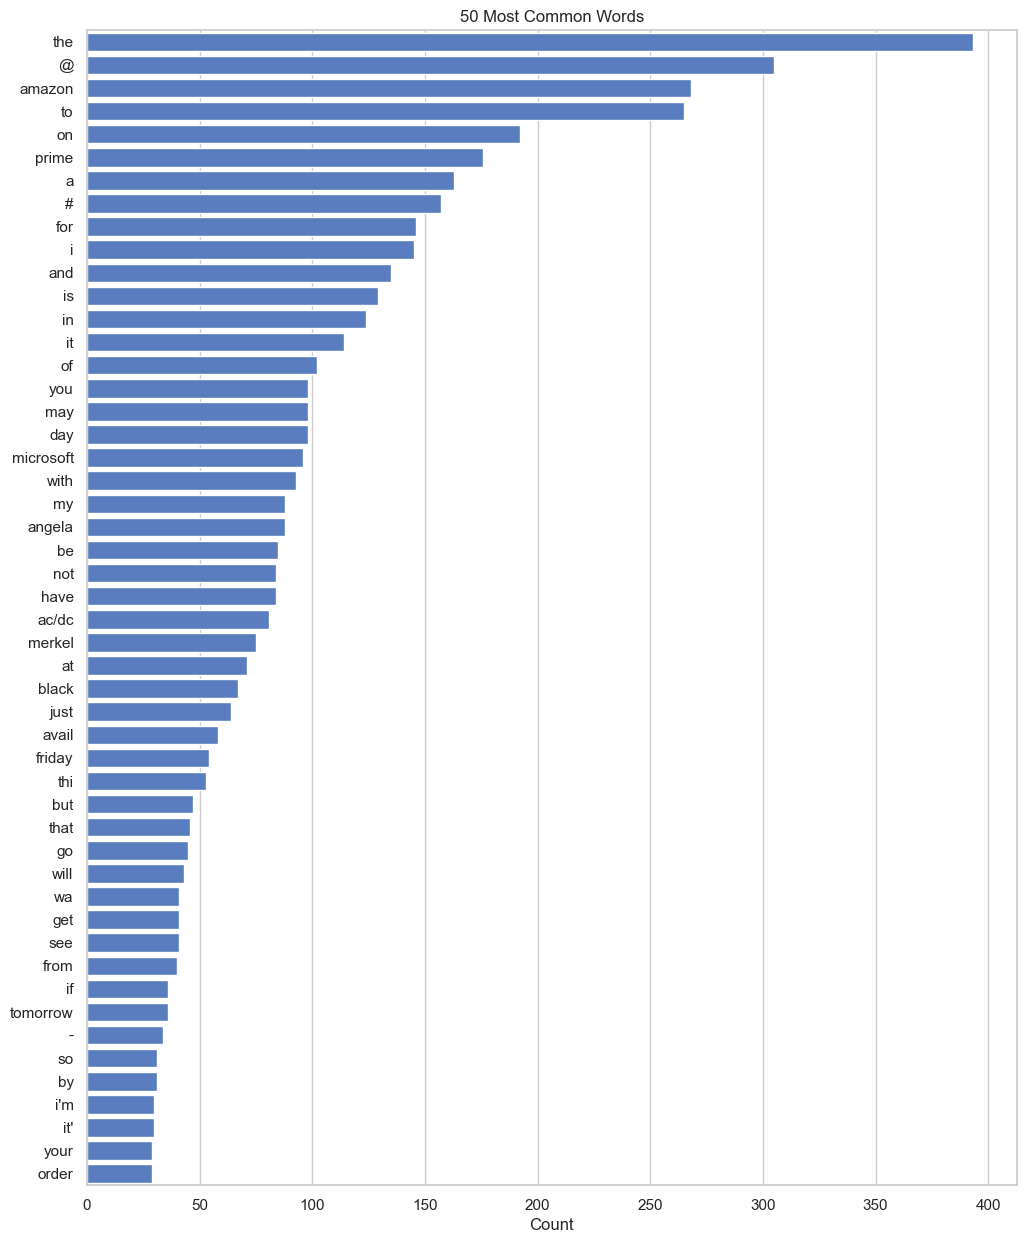

In [14]:
most_common = words.most_common(50)
show_histogram(most_common, "50 Most Common Words")

Widać, że nie wszystkie tokeny to słowa. Ponieważ budujemy słownik słów, które będą wykorzystywane do klasyfikacji tekstów, usuńmy podstawowe tokeny, które nie niosą żadnej informacji.

**Zad. 6: Usuń znaki interpunkcyjne z kolekcji words i powtórz analizę. Czy w przypadku badania opinii trzeba wyrzucić wszystkie znaki interpunkcyjne?**

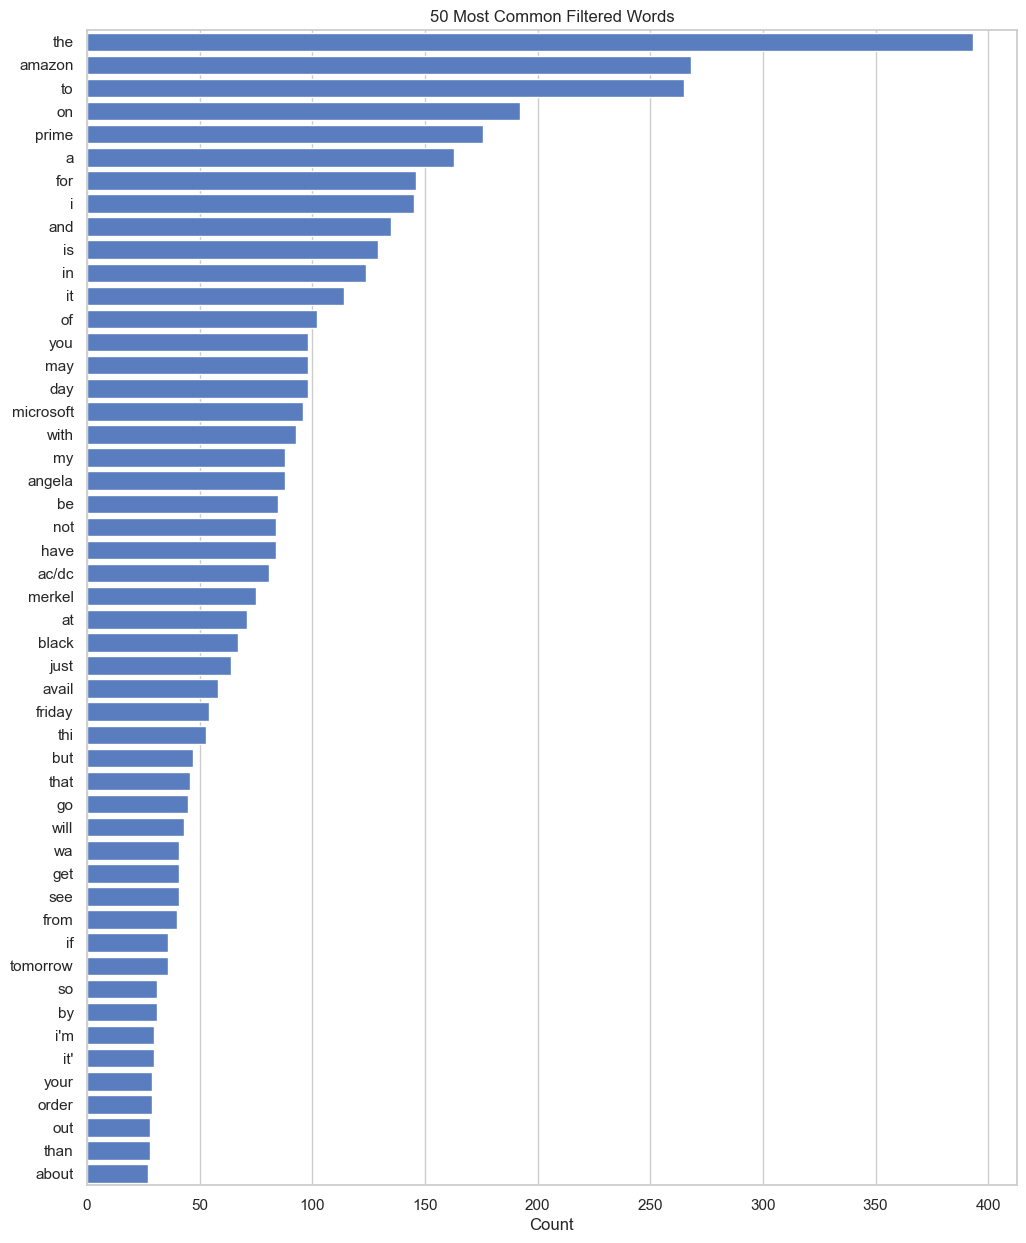

In [15]:
import string

punctuation_marks = list(string.punctuation)

for word in punctuation_marks:
    if word in words:
        del words[word]
        
most_common = words.most_common(50)
show_histogram(most_common, "50 Most Common Filtered Words")

Wyraźnie widać, że nawet bez znaków intepunkcyjnych pozostało dużo zbędnych tokenów. Poniżej lista słów, które często są oznaczane jako tzw. stopwords, czyli słowa występujące często a nie niosące informacji.

In [16]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
            "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
            "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him",
            "himself", "his", "how", "i", "in", "into", "is", "it", "its", "itself", "let", "me", "more", "most", "my",
            "myself", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "sha",
            "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves",
            "then", "there", "there's", "these", "they", "this", "those", "through", "to", "until", "up", "very",
            "was", "we", "were", "what", "when", "where", "which", "while", "who","whom", "with", "would", "you",
            "your", "yours", "yourself", "yourselves",
            "n't", "'s", "'ll", "'re", "'d", "'m", "'ve",
            "above", "again", "against", "below", "but", "cannot", "down", "few", "if", "no", "nor", "not", "off",
            "out", "over", "same", "too", "under", "why"]

**Zad. 7: Korzystając z listy `sotpwords` usuń z kolekcji `words` popularne stopwords i ponów analizę. Czy wszystkie stopwords zawsze należy wyrzucać? Czy słowa takie jak "not" mogą być nośnikiem opinii? Jeśli masz jeszcze dużo czasu, możesz przeanalizować listę słów w nltk.corpus.stopwords.words('english')?**

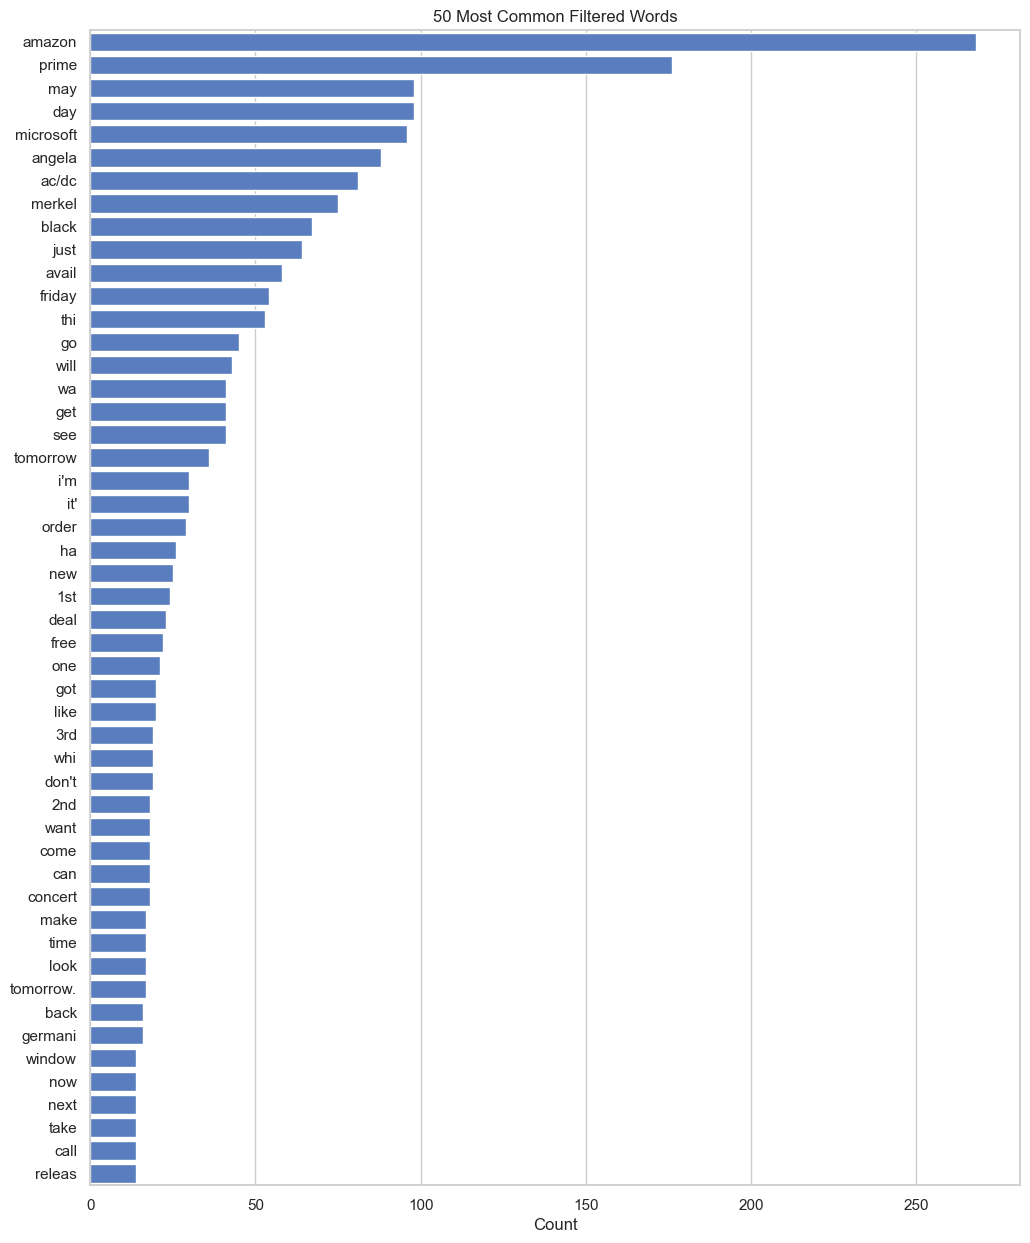

In [17]:
for word in stopwords:
    if word in words:
        del words[word]

most_common = words.most_common(50)
show_histogram(most_common, "50 Most Common Filtered Words")

Oprócz tokenów, które występują zbyt często, problemem bywają również najrzadsze tokeny.

**Zad. 8: Przeanalizuj 100 listę najrzadszych tokenów. Czy wszystkie tokeny są rzeczywiście rzadkie? Czy jakieś typy tokenów powtarzają się? Jak myślisz, co najlepiej zrobić z takimi tokenami jak 1, 2, 3... 10%, 20%, 30%..., 12:00, 19:50, 22:30, ..., 2005, 2010, 1995..., 10\$, 20\$, 30\$... ?**

In [18]:
least_common_words = words.most_common()[::-1]
least_100_common_words = least_common_words[:100]
print(least_100_common_words)

[('columnista', 1), ('invas', 1), ('organis', 1), ('freedomoffreedo', 1), ('reaganitegop', 1), ('piti', 1), ('restor', 1), ('refugeeswelcom', 1), ('http://t.co/ooqdqdbwit', 1), ('bold...', 1), ('inclin', 1), ('shown', 1), ('rare', 1), ('europe,', 1), ('racist.', 1), ('xenophob', 1), ('action', 1), ('critic', 1), ('concern', 1), ('citizen', 1), ('http://t.co/cvh6nkcxoq', 1), ('as...', 1), ('sunday,', 1), ('http://t.co/led4qywrr', 1), ('http://t.co/d7il2qp6di', 1), ('humanitarian.', 1), ('graduates.', 1), ('http://t.co/9g3het8dzd', 1), ('newsfusionapp', 1), ('(via', 1), ('must', 1), ('whole', 1), ('europ', 1), ('http://t.co/gvvyrjpcop', 1), ('migrantcrisi', 1), ('migrantmarch', 1), ('http://t.co/wq1s3fxdd2', 1), ('exodu', 1), ('term?', 1), ('ran', 1), ('africa?', 1), ('nobodi', 1), ('nishelo', 1), ('smith_rfkennedi', 1), ('http://t.co/gral0rmwv4', 1), ('exampl', 1), ('http://t.co/lsi57oqqi0', 1), ('sweden?', 1), ('http://t.co/z4d0iflavq', 1), ('appar', 1), ('http://t.co/ifvnbuqfgf', 1), 

Na tym etapie w zmiennej `words` mamy wstępnie przygotowany słownik. Jak widać słownik możnaby jeszcze ulepszyć, ale w tym ćwiczeniu poprzestaniemy na tym co do tej pory zrobiliśmy.

## Klasyfikacja

Mając słownik zamienimy przykłady uczące na reprezentację bag of words (BOW). W tej reprezentacji każdy przykład uczący (pojedynczy dokument tekstowy) przyjmuje formę wektora liczb. Każda pozycja w wektorze oznacza kolejne słowo ze słownika, a liczba na danej pozycji mówi czy (0-1) lub jak często (0-k) dane słowo występuje w tekście. Taka reprezentacja wektorowa ma tę zaletę, że można ją łatwo rozszerzać o dodatkowe atrybuty.

**Zad. 9: Przeanalizuj poniższy kod tworzący reprezentację bag-of-words. Co to jest `csr_matrix`? Czy wykorzystanie tej klasy jest konieczne?**

In [19]:
def create_bow(documents, features):
    row = []
    col = []
    data = []

    labels = []

    for i in documents.index:
        tweet = BeforeTokenizationNormalizer.normalize(documents.iloc[i, 2])
        label = documents.iloc[i, 1]
        tweet_tokens = TweetTokenizer.tokenize(tweet)

        labels.append(label)
        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

Na koniec wykorzystajmy dotychczasową wiedzę, żeby nauczyć i przetestować klasyfikator.

**Zad. 10: Sprawdź działanie klasyfikatora Random Forest na przetworzonych wcześniej danych. Jak na trafność klasyfikacji wpływa parametr min_word_count?**

In [20]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

min_word_count = 5

train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
common_words = list([k for k, v in words.most_common() if v > min_word_count])

feature_dict = {}
for word in common_words:
    feature_dict[word] = len(feature_dict)

print("Training classifier...")
X_train, y_train = create_bow(train_tweets, feature_dict)
list_of_labels = list(set(y_train))
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
classifier.fit(X_train, y_train)

print("Testing...")
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
X_test, y_test = create_bow(test_tweets, feature_dict)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.25806452 0.19047619 0.71864407]
Precision [0.25       0.42105263 0.62352941]
Recall    [0.26666667 0.12307692 0.848     ]


# Pretrenowane modele

Powyższe ćwiczenia pokazały jak na niskim poziomie można pracować z tekstem. Wraz z rozwojem architektury Transformer, często można przeskoczyć te kroki i wykonać zadanie korzystając z gotowych modeli. W tym celu zajrzyj na stronę projektu [HuggingFace](https://huggingface.co/docs/transformers/quicktour). Tamtejsze wprowadzenie, również oparte jest o zadanie sentiment analysis.

**Zad. 11: Spróbuj zaklasyfikować tweety za pomocą `pipeline("sentiment-analysis")` z HuggingFace.**

In [21]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets.iat[i, 0])
    print(tweet)
    print(classifier(tweet))

dear @microsoft the newooffice for mac is great and all, but no lync update? c'mon.
[{'label': 'NEGATIVE', 'score': 0.9935407042503357}]
@microsoft how about you make a system that doesn't eat my friggin discs. this is the 2nd time this has happened and i am so sick of it!
[{'label': 'NEGATIVE', 'score': 0.9992417097091675}]
not available
[{'label': 'NEGATIVE', 'score': 0.9997838139533997}]
not available
[{'label': 'NEGATIVE', 'score': 0.9997838139533997}]
if i make a game as a #windows10 universal app. will #xboxone owners be able to download and play it in november? @majornelson @microsoft
[{'label': 'NEGATIVE', 'score': 0.9941667318344116}]
microsoft, i may not prefer your gaming branch of business. but, you do make a damn fine operating system. #windows10 @microsoft
[{'label': 'POSITIVE', 'score': 0.9989448189735413}]
@mikewolf1980 @microsoft i will be downgrading and let #windows10 be out for almost the 1st yr b4 trying it again. #windows10fail
[{'label': 'NEGATIVE', 'score': 0.99

**Zad. 12: Spróbuj [douczyć model na swoich danych](https://huggingface.co/docs/transformers/training).** 

In [46]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [104]:
def tokenize_function(data):
    return tokenizer(data['text'], padding="max_length", truncation=True)

In [105]:
from datasets import Dataset

In [120]:
tweets_train = pd.read_csv("tweets_train.tsv", sep='\t', header=None, usecols=[1, 2], names=['label', 'text'])
tweets_train.reset_index(drop=True, inplace=True)
tweets_train['label'] = tweets_train['label'].replace({'negative': 0, 'neutral': 1, 'positive': 2})

tweets_train_ds = Dataset.from_pandas(tweets_train)

tokenized_train_tweets = tweets_train_ds.map(tokenize_function, batched=True)
tokenized_train_tweets

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 600
})

In [121]:
tweets_test = pd.read_csv("tweets_test.tsv", sep='\t', header=None, usecols=[1, 2], names=['label', 'text'])
tweets_test.reset_index(drop=True, inplace=True)
tweets_test['label'] = tweets_test['label'].replace({'negative': 0, 'neutral': 1, 'positive': 2})

tweets_test_ds = Dataset.from_pandas(tweets_test)

tokenized_test_tweets = tweets_test_ds.map(tokenize_function, batched=True)
tokenized_test_tweets

Map:   0%|          | 0/205 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 205
})

In [122]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [123]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [124]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [125]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [126]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [127]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_tweets,
    eval_dataset=tokenized_test_tweets,
    compute_metrics=compute_metrics,
)

In [128]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.951882,0.473171
2,No log,1.002191,0.473171
3,No log,1.047950,0.585366


TrainOutput(global_step=225, training_loss=0.6660592990451389, metrics={'train_runtime': 2638.0131, 'train_samples_per_second': 0.682, 'train_steps_per_second': 0.085, 'total_flos': 473604151910400.0, 'train_loss': 0.6660592990451389, 'epoch': 3.0})

In [85]:
# import torch
# torch.cuda.empty_cache()